In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Optional (If using Colab)

In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/COMS4995/COMS4995_Project")
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/COMS4995/COMS4995_Project']

### Optional (Install necessary dependecy in colab)

In [ ]:
!pip install category_encoders
!pip install -U scikit-learn

     |████████████████████████████████| 82 kB 329 kB/s 


In [1]:
from dataset.Preprocess import Preprocess, MissingHandler
from dataset.Encoder import DateHourEncoder, DateWeekEncoder, DateMonthEncoder, DateYearEncoder
from utils.read_file import read_from_csv
from sklearn.model_selection import train_test_split

/Users/maochenhui/miniforge3/envs/DL/lib/python3.8/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read data

In [3]:
file = "data/transaction.csv"
df = read_from_csv(file)
df

Load DataFrame!


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False,False
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,0.00,NaN,NaN,NaN,True,NaN,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90.0,...,NaN,1095.04,NaN,NaN,NaN,False,NaN,NaN,False,False
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,9.0,...,NaN,1214.96,NaN,NaN,NaN,False,NaN,NaN,False,False
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,2.0,...,NaN,1233.85,NaN,NaN,NaN,False,NaN,NaN,False,False
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,9.0,...,NaN,1283.28,NaN,NaN,NaN,False,NaN,NaN,False,False


### Transformation

#### Transform Date variable

In [4]:
he = DateHourEncoder("%Y-%m-%dT%H:%M:%S")
me = DateMonthEncoder("%Y-%m-%dT%H:%M:%S")
we = DateWeekEncoder("%Y-%m-%dT%H:%M:%S")
ye = DateYearEncoder("%Y-%m-%dT%H:%M:%S")

df["transactionDateTime_hour"] = he.transform(df["transactionDateTime"])
df["transactionDateTime_weekday"] = we.transform(df["transactionDateTime"])
df["transactionDateTime_month"] = me.transform(df["transactionDateTime"])
# df["transactionDateTime_year"] = ye.transform(df["transactionDateTime"])

# df["accountOpenDate_year"] = DateYearEncoder("%Y-%m-%d").transform(df["accountOpenDate"])
# df["accountOpenDate_weekday"] = DateWeekEncoder("%Y-%m-%d").transform(df["accountOpenDate"])
# df["accountOpenDate_month"] = DateMonthEncoder("%Y-%m-%d").transform(df["accountOpenDate"])

# df["dateOfLastAddressChange_year"] = DateYearEncoder("%Y-%m-%d").transform(df["dateOfLastAddressChange"])
# df["dateOfLastAddressChange_weekday"] = DateWeekEncoder("%Y-%m-%d").transform(df["dateOfLastAddressChange"])
# df["dateOfLastAddressChange_month"] = DateMonthEncoder("%Y-%m-%d").transform(df["dateOfLastAddressChange"])

# df["currentExpDate_year"] = DateYearEncoder("%m/%Y").transform(df["currentExpDate"])
# df["currentExpDate_month"] = DateMonthEncoder("%m/%Y").transform(df["currentExpDate"])

#### Transform CVV

In [5]:
def num_digits_mismatching_cvv(cardCVV,enteredCVV):
    num_mismatch=0
    cardCVV=str(cardCVV)
    enteredCVV=str(enteredCVV)
    if len(cardCVV)==len(enteredCVV):
        for i in range(len(cardCVV)):
            if cardCVV[i]!=enteredCVV[i]:
                num_mismatch+=1
    return num_mismatch
df['matchingCVV'] = df.apply(lambda x: num_digits_mismatching_cvv(x.cardCVV, x.enteredCVV), axis=1)

In [6]:
df

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_hour,transactionDateTime_weekday,transactionDateTime_month,matchingCVV
0,737265056,737265056,5000.0,5000.00,2016-08-13T14:27:32,98.55,Uber,US,US,2.0,...,NaN,False,NaN,NaN,False,False,14,5,8,True
1,737265056,737265056,5000.0,5000.00,2016-10-11T05:05:54,74.51,AMC #191138,US,US,9.0,...,NaN,True,NaN,NaN,False,False,5,1,10,True
2,737265056,737265056,5000.0,5000.00,2016-11-08T09:18:39,7.47,Play Store,US,US,9.0,...,NaN,False,NaN,NaN,False,False,9,1,11,True
3,737265056,737265056,5000.0,5000.00,2016-12-10T02:14:50,7.47,Play Store,US,US,9.0,...,NaN,False,NaN,NaN,False,False,2,5,12,True
4,830329091,830329091,5000.0,5000.00,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,2.0,...,NaN,True,NaN,NaN,False,False,21,3,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,732852505,50000.0,48904.96,2016-12-22T18:44:12,119.92,Lyft,US,US,90.0,...,NaN,False,NaN,NaN,False,False,18,3,12,True
786359,732852505,732852505,50000.0,48785.04,2016-12-25T16:20:34,18.89,hulu.com,US,US,9.0,...,NaN,False,NaN,NaN,False,False,16,6,12,True
786360,732852505,732852505,50000.0,48766.15,2016-12-27T15:46:24,49.43,Lyft,US,US,2.0,...,NaN,False,NaN,NaN,False,False,15,1,12,True
786361,732852505,732852505,50000.0,48716.72,2016-12-29T00:30:55,49.89,walmart.com,US,US,9.0,...,NaN,False,NaN,NaN,False,False,0,3,12,True


### Remove some unwanted Variables

In [7]:
df = df.drop(["accountNumber", 
              "accountOpenDate", 
              "dateOfLastAddressChange", 
              "currentExpDate", 
              "transactionDateTime"], axis=1)

In [8]:
df

,customerId,creditLimit,availableMoney,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,...,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud,transactionDateTime_hour,transactionDateTime_weekday,transactionDateTime_month,matchingCVV
0,737265056,5000.0,5000.00,98.55,Uber,US,US,2.0,1.0,rideshare,...,NaN,False,NaN,NaN,False,False,14,5,8,True
1,737265056,5000.0,5000.00,74.51,AMC #191138,US,US,9.0,1.0,entertainment,...,NaN,True,NaN,NaN,False,False,5,1,10,True
2,737265056,5000.0,5000.00,7.47,Play Store,US,US,9.0,1.0,mobileapps,...,NaN,False,NaN,NaN,False,False,9,1,11,True
3,737265056,5000.0,5000.00,7.47,Play Store,US,US,9.0,1.0,mobileapps,...,NaN,False,NaN,NaN,False,False,2,5,12,True
4,830329091,5000.0,5000.00,71.18,Tim Hortons #947751,US,US,2.0,1.0,fastfood,...,NaN,True,NaN,NaN,False,False,21,3,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
786358,732852505,50000.0,48904.96,119.92,Lyft,US,US,90.0,1.0,rideshare,...,NaN,False,NaN,NaN,False,False,18,3,12,True
786359,732852505,50000.0,48785.04,18.89,hulu.com,US,US,9.0,1.0,online_subscriptions,...,NaN,False,NaN,NaN,False,False,16,6,12,True
786360,732852505,50000.0,48766.15,49.43,Lyft,US,US,2.0,1.0,rideshare,...,NaN,False,NaN,NaN,False,False,15,1,12,True
786361,732852505,50000.0,48716.72,49.89,walmart.com,US,US,9.0,99.0,online_retail,...,NaN,False,NaN,NaN,False,False,0,3,12,True


### Change some data type
We notice that some data type is int64 or float but actually a categorical data, so we need to change those data into categorical data

In [11]:
# objects = ["customerId",
#            "transactionDateTime_hour", 
#            "transactionDateTime_weekday", 
#            "transactionDateTime_weekday", 
#            "transactionDateTime_month", 
#            "transactionDateTime_year", 
#            "accountOpenDate_year", 
#            "accountOpenDate_weekday", 
#            "accountOpenDate_month", 
#            "dateOfLastAddressChange_year", 
#            "dateOfLastAddressChange_weekday", 
#            "dateOfLastAddressChange_month", 
#            "currentExpDate_year", 
#            "currentExpDate_month"]
objects = ["customerId",
           "creditLimit",
          #  "availableMoney",
           "posEntryMode",
           "posConditionCode",
           "cardCVV", 
           "enteredCVV", 
           "cardLast4Digits",
           "transactionDateTime_hour", 
           "transactionDateTime_weekday",
           "transactionDateTime_month",
           "matchingCVV"]
          #  "accountOpenDate_year",
          #  "accountOpenDate_weekday", 
          #  "accountOpenDate_month", 
          #  "dateOfLastAddressChange_year", 
          #  "dateOfLastAddressChange_weekday", 
          #  "dateOfLastAddressChange_month", 
          #  "currentExpDate_year", 
          #  "currentExpDate_month"]
df[objects] = df[objects].astype(str)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 786363 entries, 0 to 786362
Data columns (total 28 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   customerId                   786363 non-null  object 
 1   creditLimit                  786363 non-null  float64
 2   availableMoney               786363 non-null  float64
 3   transactionAmount            786363 non-null  float64
 4   merchantName                 786363 non-null  object 
 5   acqCountry                   781801 non-null  object 
 6   merchantCountryCode          785639 non-null  object 
 7   posEntryMode                 782309 non-null  object 
 8   posConditionCode             785954 non-null  object 
 9   merchantCategoryCode         786363 non-null  object 
 10  cardCVV                      786363 non-null  object 
 11  enteredCVV                   786363 non-null  object 
 12  cardLast4Digits              786363 non-null  object 
 13 

### Randomly sample from the Dataset (optional)
Dataset are extremely huge in this cases, so, we can choose to sample part of the data from the dataset

In [ ]:
df = df.sample(n=200000, random_state=23)

### Preprocess the data
Including Handle the missing data, Scale the numerical data, Encode the categorical data into Onehot encoding and ordinal encoding

In [ ]:
# Missing Handler
handler = MissingHandler(df, impute=False, target="isFraud")
X, y = handler.get_features(), handler.get_labels()


# Train validation Test split
dev_x, test_x, dev_y, test_y = train_test_split(X, y, test_size=0.2, random_state=23, stratify=y)
train_x, val_x, train_y, val_y = train_test_split(dev_x, dev_y, test_size=0.25, random_state=23, stratify=dev_y)

o_features = ['customerId', 
              'acqCountry', 
              'merchantCountryCode', 
              'posEntryMode', 
              'posConditionCode', 
              'merchantCategoryCode', 
              'transactionType', 
              'cardPresent', 
              'expirationDateKeyInMatch', 
              'transactionDateTime_hour', 
              'transactionDateTime_weekday', 
              'transactionDateTime_month', 
              'matchingCVV']

t_features = ['customerId', 'merchantName', 'cardCVV', 'enteredCVV', 'cardLast4Digits']

# default encoding is to encode all categorical data with ONEHOT encoding
# You can choose whether to implement oridinal encoding or Target encoding by specifying corresponding features' name
# e.g. p = Preprocess(X, y, handler, oridinal_features=o_features)
p = Preprocess(X, y, handler, target_features=t_features)
p.__fit__()


train_x, train_y = p.preprocessor.transform(train_x), p.tar_handler.transform(train_y)
val_x, val_y = p.preprocessor.transform(val_x), p.tar_handler.transform(val_y)
test_x, test_y = p.preprocessor.transform(test_x), p.tar_handler.transform(test_y)

num_f: ['transactionAmount', 'availableMoney', 'currentBalance', 'creditLimit'], cate_f: ['merchantCategoryCode', 'posEntryMode', 'merchantCountryCode', 'transactionDateTime_hour', 'acqCountry', 'transactionDateTime_month', 'matchingCVV', 'expirationDateKeyInMatch', 'cardPresent', 'transactionType', 'posConditionCode', 'transactionDateTime_weekday'], ordinal_features: None, target_features: ['customerId', 'merchantName', 'cardCVV', 'enteredCVV', 'cardLast4Digits']


In [ ]:
train_x.shape

(118479, 96)

### Dealing with Imbalanced (optional)
In this scenario, the data are highly imbalanced, so we may want to use some sampling mechanisms (including under sampling, over sampling) to handle the imbalanced data

In [ ]:
from dataset.Sampling import Sampling, SampleMechanism

# You can apply different sampling strategies by changing the mechanism
# So far supporting under sampling -  SampleMechanism.under (default)
# Over sampling - SampleMechanism.over
# SMOTE sampling - SampleMechanism.SMOTE
Sampler1 = Sampling(train_x, train_y, mechanism=SampleMechanism.under)
train_x_resample, train_y_resample = Sampler1.get_features(), Sampler1.get_labels()
Sampler2 = Sampling(val_x, val_y)
val_x_resample, val_y_resample = Sampler2.get_features(), Sampler2.get_labels()
Sampler3 = Sampling(test_x, test_y)
test_x_resample, test_y_resample = Sampler3.get_features(), Sampler3.get_labels()

In [ ]:
print(f"resample train size: {train_x_resample.shape}, \nresample validation size: {val_x_resample.shape}, \nresample test size: {test_x_resample.shape}")

resample train size: (3594, 96), 
resample validation size: (1198, 96), 
resample test size: (1198, 96)


In [ ]:
import numpy as np
from collections import Counter

In [ ]:
print(f"resample train size, positive vs negative: {Counter(train_y_resample)}\nresample validation size, positive vs negative: {Counter(val_y_resample)}\nresample test size: {Counter(val_y_resample)}")

resample train size, positive vs negative: Counter({0: 1797, 1: 1797})
resample validation size, positive vs negative: Counter({0: 599, 1: 599})
resample test size: Counter({0: 599, 1: 599})


### Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay
import matplotlib.pyplot as plt

### Confusion Matrix

In [ ]:
import seaborn as sns
def plot_confusion(y_pred, y_true):
    conf = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print()
    print(f'Accuracy: {acc}')
    sns.heatmap(conf,
                cmap='Blues',
                cbar=False,
                annot=True,
                fmt='g',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'],
                annot_kws={"size": 20}
                )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [ ]:
%%time
rf_clf = RandomForestClassifier().fit(train_x, train_y)

CPU times: user 1min 37s, sys: 61.5 ms, total: 1min 37s
Wall time: 1min 37s


### Evaluation

In [66]:
print('RandomForest test acc is : ', accuracy_score(test_y, rf_clf.predict(test_x)))
print('RandomForest test precision is : ', precision_score(test_y, rf_clf.predict(test_x), pos_label=1))
print('RandomForest test recall is : ', recall_score(test_y, rf_clf.predict(test_x), pos_label=1))
print('RandomForest test f1 is : ', f1_score(test_y, rf_clf.predict(test_x), pos_label=1))
print('RandomForest test auc is : ', roc_auc_score(test_y, np.max(rf_clf.predict_proba(test_x),1)))

RandomForest test acc is :  0.9855417415744563
RandomForest test precision is :  1.0
RandomForest test recall is :  0.04674457429048414
RandomForest test f1 is :  0.08931419457735247
RandomForest test auc is :  0.1399450439029826


In [ ]:
# Precesion-Recall curve & ROC curve 
from sklearn.metrics import roc_curve

y_score = np.max(rf_clf.predict_proba(test_x),1)

rf_prec, rf_recall, _ = precision_recall_curve(test_y, y_score)

rf_fpr, rf_tpr, _ = roc_curve(test_y, y_score, pos_label=rf_clf.classes_[1])

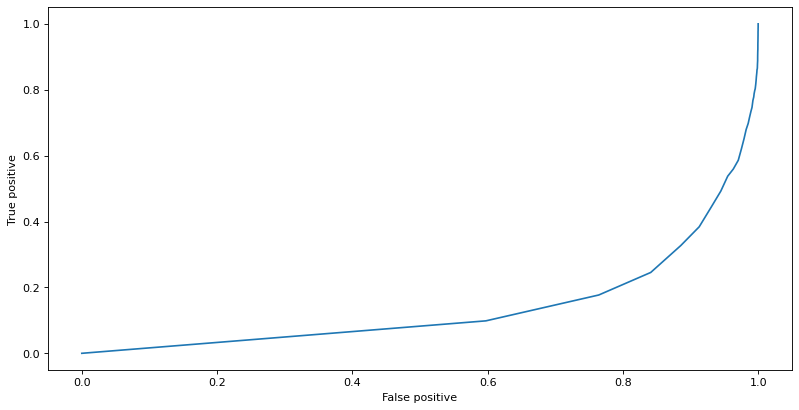

In [ ]:
fig = plt.figure(figsize=(12,6), dpi=80)
ax = fig.add_subplot(1,1,1)
ax.plot(rf_fpr, rf_tpr)
ax.set_xlabel("False positive")
ax.set_ylabel("True positive")
plt.show()